In [1]:
from PIL import Image
import numpy as np
import torch
import torchvision

# Check for multiple GPUs and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPU")
    multi_gpu = True
else:
    multi_gpu = False
print(f"Using device: {device}")

Using 8 GPU
Using device: cuda


## 1. Data preparation
This prepares and transform the dataset into appropriate dataloaders.

In [2]:
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import os

In [3]:
train_transform = A.Compose([
        A.Resize(768, 1024),
        A.HorizontalFlip(),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
        ToTensorV2(),
    ])

val_transform = A.Compose([
    A.Resize(768, 1024),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

In [4]:
from Datasets import Cityscapes

In [5]:
root_dir = 'data'

train_dataset = Cityscapes(root=root_dir, split='train', mode='fine', target_type='labelTrainIds',
                           transforms=train_transform)
val_dataset = Cityscapes(root=root_dir, split='val', mode='fine', target_type='labelTrainIds',
                         transforms=val_transform)

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=24,
                              shuffle=True, num_workers=8, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=24,
                            shuffle=True, num_workers=8, pin_memory=True)

## 2. Training

In [7]:
import torch.nn as nn
import torch.optim as optim
from torchmetrics import JaccardIndex
from tqdm import tqdm

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(


In [8]:
# Model
weights = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT
model = torchvision.models.segmentation.deeplabv3_resnet50(weights=weights)

# Training preparation
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Loss metric
miou = JaccardIndex(task="multiclass", num_classes=20).to(device)

In [9]:
## Preparing the model
# DeepLabV3 ResNet
model.classifier[4] = nn.Conv2d(256, 20, kernel_size=1)
if model.aux_classifier:
    model.aux_classifier[4] = nn.Conv2d(256, 20, kernel_size=1)

if multi_gpu:
    model = torch.nn.DataParallel(model)
model = model.to(device)

In [10]:
# Training
num_epochs = 20

model.to(device)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    miou.reset()

    train_progress = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs} - Training', unit='batch') # Monitor training progress
    for inputs, labels in train_progress:
        inputs = inputs.to(device)
        labels = labels.to(device).long().squeeze(1)
        
        optimizer.zero_grad()
        outputs = model(inputs)['out']
        predicted = torch.argmax(outputs, dim=1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        miou.update(predicted, labels)

        train_progress.set_postfix(loss=running_loss/len(train_progress)) # Monitor training progress

    miou_accuracy = miou.compute().item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_dataloader)}, Train MIoU: {miou_accuracy}")

    model.eval()
    correct = 0
    total = 0
    miou.reset()

    val_progress = tqdm(val_dataloader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation', unit='batch') # Monitor validation progress
    with torch.no_grad():
        for inputs, labels in val_progress:
            inputs = inputs.to(device)
            labels = labels.to(device).long().squeeze(1)
            
            outputs = model(inputs)['out']
            predicted = torch.argmax(outputs, dim=1)
            
            total += labels.numel()           
            correct += (predicted == labels).sum().item()

            miou.update(predicted, labels)

            val_progress.set_postfix(accuracy=100 * correct / total) # Monitor validation progress

    val_accuracy = 100 * correct / total
    miou_accuracy = miou.compute().item()
    print(f"Validation Accuracy: {val_accuracy}%, Val MIoU: {miou_accuracy}")

Epoch 1/20 - Training: 100%|██████████| 124/124 [01:10<00:00,  1.76batch/s, loss=1.46]


Epoch 1/20, Loss: 1.4624110623713462, Train MIoU: 0.25927895307540894


Epoch 1/20 - Validation: 100%|██████████| 21/21 [00:12<00:00,  1.73batch/s, accuracy=86.2]


Validation Accuracy: 86.17676671346028%, Val MIoU: 0.3027498424053192


Epoch 2/20 - Training: 100%|██████████| 124/124 [01:00<00:00,  2.06batch/s, loss=1.1]  


Epoch 2/20, Loss: 1.100723672297693, Train MIoU: 0.3481335937976837


Epoch 2/20 - Validation: 100%|██████████| 21/21 [00:08<00:00,  2.34batch/s, accuracy=88]  


Validation Accuracy: 88.009654490153%, Val MIoU: 0.39231759309768677


Epoch 3/20 - Training: 100%|██████████| 124/124 [01:00<00:00,  2.05batch/s, loss=1]    


Epoch 3/20, Loss: 1.0048969690838168, Train MIoU: 0.42766594886779785


Epoch 3/20 - Validation: 100%|██████████| 21/21 [00:08<00:00,  2.37batch/s, accuracy=88.4]


Validation Accuracy: 88.41971842447917%, Val MIoU: 0.42807602882385254


Epoch 4/20 - Training: 100%|██████████| 124/124 [00:59<00:00,  2.07batch/s, loss=0.932]


Epoch 4/20, Loss: 0.9322834923382728, Train MIoU: 0.47491759061813354


Epoch 4/20 - Validation: 100%|██████████| 21/21 [00:08<00:00,  2.36batch/s, accuracy=89]  


Validation Accuracy: 89.0090545654297%, Val MIoU: 0.47571104764938354


Epoch 5/20 - Training: 100%|██████████| 124/124 [00:59<00:00,  2.07batch/s, loss=0.874]


Epoch 5/20, Loss: 0.8743156617687594, Train MIoU: 0.5286222100257874


Epoch 5/20 - Validation: 100%|██████████| 21/21 [00:09<00:00,  2.28batch/s, accuracy=89.5]


Validation Accuracy: 89.47477951049805%, Val MIoU: 0.507169246673584


Epoch 6/20 - Training: 100%|██████████| 124/124 [01:00<00:00,  2.06batch/s, loss=0.817]


Epoch 6/20, Loss: 0.8165082921904903, Train MIoU: 0.5658829212188721


Epoch 6/20 - Validation: 100%|██████████| 21/21 [00:09<00:00,  2.32batch/s, accuracy=89.8]


Validation Accuracy: 89.7642214457194%, Val MIoU: 0.5415686368942261


Epoch 7/20 - Training: 100%|██████████| 124/124 [01:00<00:00,  2.05batch/s, loss=0.768]


Epoch 7/20, Loss: 0.768305076706794, Train MIoU: 0.601365327835083


Epoch 7/20 - Validation: 100%|██████████| 21/21 [00:09<00:00,  2.28batch/s, accuracy=89.2]


Validation Accuracy: 89.20376790364584%, Val MIoU: 0.5443406701087952


Epoch 8/20 - Training: 100%|██████████| 124/124 [01:00<00:00,  2.06batch/s, loss=0.725]


Epoch 8/20, Loss: 0.7248004391308753, Train MIoU: 0.6377776265144348


Epoch 8/20 - Validation: 100%|██████████| 21/21 [00:08<00:00,  2.36batch/s, accuracy=90.1]


Validation Accuracy: 90.10428136189779%, Val MIoU: 0.5750955939292908


Epoch 9/20 - Training: 100%|██████████| 124/124 [01:00<00:00,  2.06batch/s, loss=0.683]


Epoch 9/20, Loss: 0.682584906778028, Train MIoU: 0.6534965634346008


Epoch 9/20 - Validation: 100%|██████████| 21/21 [00:08<00:00,  2.43batch/s, accuracy=89.7]


Validation Accuracy: 89.66526463826497%, Val MIoU: 0.5643123388290405


Epoch 10/20 - Training: 100%|██████████| 124/124 [01:00<00:00,  2.04batch/s, loss=0.641]


Epoch 10/20, Loss: 0.640626294958976, Train MIoU: 0.6931007504463196


Epoch 10/20 - Validation: 100%|██████████| 21/21 [00:08<00:00,  2.35batch/s, accuracy=90.6]


Validation Accuracy: 90.57831319173177%, Val MIoU: 0.6085596084594727


Epoch 11/20 - Training: 100%|██████████| 124/124 [00:59<00:00,  2.09batch/s, loss=0.608]


Epoch 11/20, Loss: 0.6080163020280099, Train MIoU: 0.7166111469268799


Epoch 11/20 - Validation: 100%|██████████| 21/21 [00:08<00:00,  2.39batch/s, accuracy=90.4]


Validation Accuracy: 90.35966237386067%, Val MIoU: 0.6145764589309692


Epoch 12/20 - Training: 100%|██████████| 124/124 [01:00<00:00,  2.06batch/s, loss=0.579]


Epoch 12/20, Loss: 0.5787315017754032, Train MIoU: 0.7261962294578552


Epoch 12/20 - Validation: 100%|██████████| 21/21 [00:09<00:00,  2.32batch/s, accuracy=90.6]


Validation Accuracy: 90.58157755533854%, Val MIoU: 0.6215730905532837


Epoch 13/20 - Training: 100%|██████████| 124/124 [00:59<00:00,  2.08batch/s, loss=0.544]


Epoch 13/20, Loss: 0.5443206232401633, Train MIoU: 0.7506853342056274


Epoch 13/20 - Validation: 100%|██████████| 21/21 [00:08<00:00,  2.39batch/s, accuracy=90.6]


Validation Accuracy: 90.59117838541667%, Val MIoU: 0.624590277671814


Epoch 14/20 - Training: 100%|██████████| 124/124 [01:00<00:00,  2.04batch/s, loss=0.515]


Epoch 14/20, Loss: 0.5146379122330297, Train MIoU: 0.7570446729660034


Epoch 14/20 - Validation: 100%|██████████| 21/21 [00:08<00:00,  2.35batch/s, accuracy=90.7]


Validation Accuracy: 90.69495213826498%, Val MIoU: 0.6097785234451294


Epoch 15/20 - Training: 100%|██████████| 124/124 [01:00<00:00,  2.06batch/s, loss=0.487]


Epoch 15/20, Loss: 0.4869146087477284, Train MIoU: 0.7692272663116455


Epoch 15/20 - Validation: 100%|██████████| 21/21 [00:09<00:00,  2.33batch/s, accuracy=90.9]


Validation Accuracy: 90.94787673950195%, Val MIoU: 0.6322909593582153


Epoch 16/20 - Training: 100%|██████████| 124/124 [01:00<00:00,  2.05batch/s, loss=0.461]


Epoch 16/20, Loss: 0.461443611691075, Train MIoU: 0.7791081666946411


Epoch 16/20 - Validation: 100%|██████████| 21/21 [00:09<00:00,  2.33batch/s, accuracy=90.7]


Validation Accuracy: 90.72533289591472%, Val MIoU: 0.6445273756980896


Epoch 17/20 - Training: 100%|██████████| 124/124 [01:00<00:00,  2.04batch/s, loss=0.444]


Epoch 17/20, Loss: 0.4438492470691281, Train MIoU: 0.7801525592803955


Epoch 17/20 - Validation: 100%|██████████| 21/21 [00:09<00:00,  2.32batch/s, accuracy=90.5]


Validation Accuracy: 90.49964930216471%, Val MIoU: 0.6316792368888855


Epoch 18/20 - Training: 100%|██████████| 124/124 [00:58<00:00,  2.10batch/s, loss=0.423]


Epoch 18/20, Loss: 0.42339525155482755, Train MIoU: 0.7869669795036316


Epoch 18/20 - Validation: 100%|██████████| 21/21 [00:08<00:00,  2.40batch/s, accuracy=90.7]


Validation Accuracy: 90.68577601114909%, Val MIoU: 0.6288691759109497


Epoch 19/20 - Training: 100%|██████████| 124/124 [01:00<00:00,  2.06batch/s, loss=0.41] 


Epoch 19/20, Loss: 0.41014967594415913, Train MIoU: 0.7888762950897217


Epoch 19/20 - Validation: 100%|██████████| 21/21 [00:08<00:00,  2.37batch/s, accuracy=90]  


Validation Accuracy: 90.04627685546875%, Val MIoU: 0.620192289352417


Epoch 20/20 - Training: 100%|██████████| 124/124 [00:59<00:00,  2.07batch/s, loss=0.406]


Epoch 20/20, Loss: 0.40558448626149085, Train MIoU: 0.7789138555526733


Epoch 20/20 - Validation: 100%|██████████| 21/21 [00:08<00:00,  2.35batch/s, accuracy=90.8]

Validation Accuracy: 90.84493967692057%, Val MIoU: 0.6160824298858643


In [11]:
# Save model
torch.save(model.state_dict(), 'checkpoints/deeplabv3resnet50_finetuned_7681024_1.pth')

## 3. Inference and evaluation

In [12]:
import matplotlib.pyplot as plt

In [13]:
CITYSCAPES_COLOR_MAP = np.array([
    [128, 64, 128], [244, 35, 232], [70, 70, 70],
    [102, 102, 156], [190, 153, 153], [153, 153, 153],
    [250, 170, 30], [220, 220, 0], [107, 142, 35],
    [152, 251, 152], [0, 130, 180], [220, 20, 60],
    [255, 0, 0], [0, 0, 142], [0, 0, 70],
    [0, 60, 100], [0, 80, 100], [0, 0, 230],
    [119, 11, 32], [255, 255, 255], [0, 0, 0],
    [255, 255, 0], [0, 255, 0], [0, 255, 255],
    [255, 0, 255], [192, 192, 192], [128, 0, 0],
    [128, 128, 0], [0, 128, 0], [128, 0, 128],
    [0, 128, 128], [0, 0, 128], [128, 128, 128],
    [192, 0, 0], [192, 192, 0], [0, 192, 0]
], dtype=np.uint8)

In [14]:
def visualize_segmentation(model, dataset, idx):
    model.eval()
    image, target = dataset[idx]
    
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))['out']
        prediction = output.argmax(1).squeeze(0).cpu().numpy()

    def decode_segmap(segmentation):
        return CITYSCAPES_COLOR_MAP[segmentation]

    segmentation_map = decode_segmap(prediction)

    # Convert the tensor image to a numpy array
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image * 255).astype(np.uint8)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(segmentation_map)
    plt.title('Segmentation')
    plt.axis('off')

    plt.show()

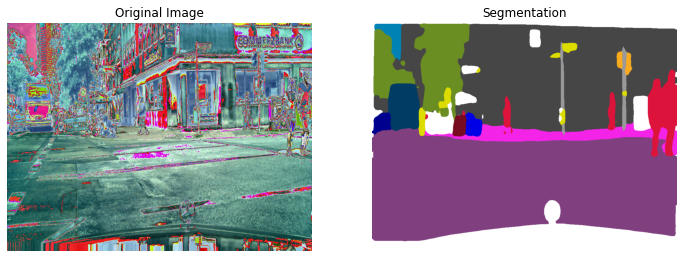

In [18]:
visualize_segmentation(model, val_dataset, idx=1)